In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numba import njit

@njit
def initialize_agents(lattice_size, num_agents, initial_infection_rate):
    num_infected = int(num_agents * initial_infection_rate)
    agents = np.zeros((num_agents, 3), dtype=np.int32)

    # Create a shuffled array of indices
    indices = np.arange(num_agents)
    np.random.shuffle(indices)

    for i in range(num_agents):
        agents[i, 0] = np.random.randint(0, lattice_size)
        agents[i, 1] = np.random.randint(0, lattice_size)
        # Infect a random 1% of the agents, based on the indices shuffled
        agents[i, 2] = 1 if i in indices[:num_infected] else 0
    
    return agents

@njit
def move_agents(agents, lattice_size, diffusion_rate):
    for i in range(agents.shape[0]):
        if np.random.random() < diffusion_rate:
            move_x = np.random.randint(-1, 2)
            move_y = np.random.randint(-1, 2)
            agents[i, 0] = (agents[i, 0] + move_x) % lattice_size
            agents[i, 1] = (agents[i, 1] + move_y) % lattice_size

@njit
def infect_agents(agents, beta, lattice_size):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1:
            for j in range(agents.shape[0]):
                if agents[j, 2] == 0 and agents[i, 0] == agents[j, 0] and agents[i, 1] == agents[j, 1]:
                    if np.random.random() < beta:
                        agents[j, 2] = 1

@njit
def update_recovery(agents, gamma):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1 and np.random.random() < gamma:
            agents[i, 2] = 2

@njit
def update_agents(agents, lattice_size, diffusion_rate, beta, gamma):
    move_agents(agents, lattice_size, diffusion_rate)
    infect_agents(agents, beta, lattice_size)
    update_recovery(agents, gamma)

In [2]:
# Simulation params
lattice_size = 100
num_agents = 1000
#beta = 0.6      # Infection rate
gamma = 0.01    # Recovery rate
diffusion_rate = 0.8  # Diffusion rate, probability to move
total_time_steps = 5000
initial_infection_rate = 0.01

In [3]:
@njit
def run_simulation(beta, gamma):
    # Initialize agents
    agents = initialize_agents(lattice_size, num_agents, initial_infection_rate)

    susceptible_count = []
    infected_count = []
    recovered_count = []

    # Run simulation and count SIR
    for step in range(total_time_steps + 1):
        state_count = np.bincount(agents[:, 2], minlength=3)
        susceptible_count.append(state_count[0])
        infected_count.append(state_count[1])
        recovered_count.append(state_count[2])
        update_agents(agents, lattice_size, diffusion_rate, beta, gamma)

    return susceptible_count, infected_count, recovered_count

## R_inf vs $\beta$ plot

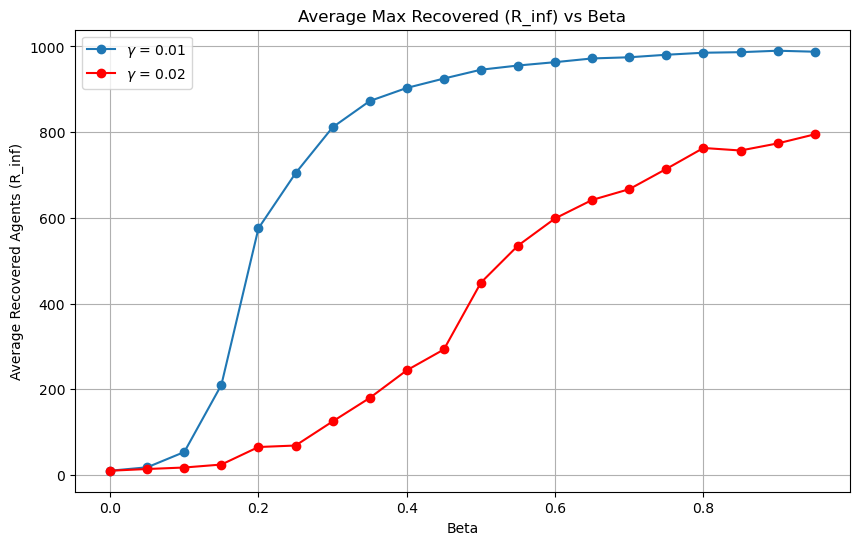

In [4]:
beta_range = np.arange(0, 1, 0.05)
num_sim = 10

R_inf_gamma_001 = []
R_inf_gamma_002 = []

gamma = 0.01
for beta in beta_range:
    total_max_recovered = 0
    for _ in range(num_sim):
        susceptible, infected, recovered = run_simulation(beta, gamma)
        total_max_recovered += max(recovered)
    average_max_recovered = total_max_recovered / num_sim
    R_inf_gamma_001.append(average_max_recovered)

gamma = 0.02
for beta in beta_range:
    total_max_recovered = 0
    for _ in range(num_sim):
        susceptible, infected, recovered = run_simulation(beta, gamma)
        total_max_recovered += max(recovered)
    average_max_recovered = total_max_recovered / num_sim
    R_inf_gamma_002.append(average_max_recovered)

plt.figure(figsize=(10, 6))
plt.plot(beta_range, R_inf_gamma_001, marker='o', linestyle='-', label='$\gamma$ = 0.01')
plt.plot(beta_range, R_inf_gamma_002, marker='o', linestyle='-', color='red', label='$\gamma$ = 0.02')
plt.title('Average Max Recovered (R_inf) vs Beta')
plt.xlabel('Beta')
plt.ylabel('Average Recovered Agents (R_inf)')
plt.legend()
plt.grid(True)
plt.show()

## R_inf vs $\beta/\gamma$ plot

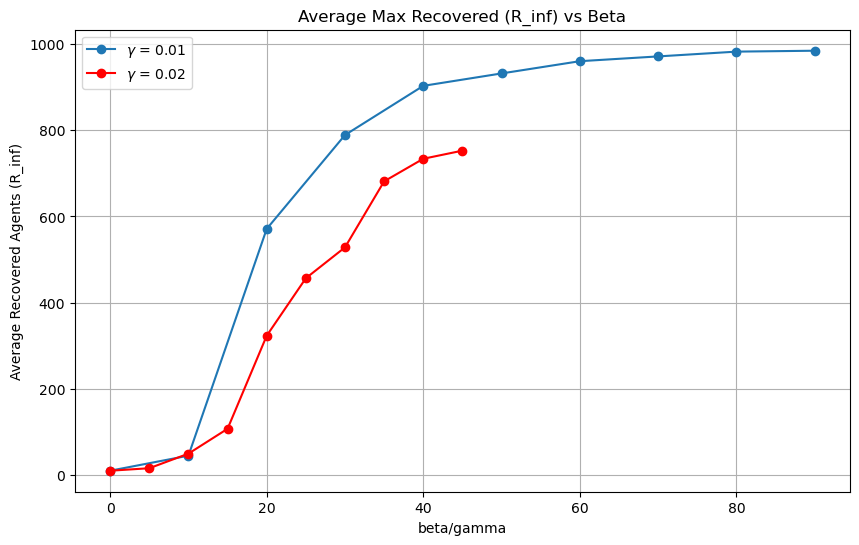

In [5]:
beta_range = np.arange(0, 1, 0.1)
num_sim = 10

R_inf_gamma_001 = []
R_inf_gamma_002 = []

gamma = 0.01
for beta in beta_range:
    total_max_recovered = 0
    for _ in range(num_sim):
        susceptible, infected, recovered = run_simulation(beta, gamma)
        total_max_recovered += max(recovered)
    average_max_recovered = total_max_recovered / num_sim
    R_inf_gamma_001.append(average_max_recovered)

gamma = 0.02
for beta in beta_range:
    total_max_recovered = 0
    for _ in range(num_sim):
        susceptible, infected, recovered = run_simulation(beta, gamma)
        total_max_recovered += max(recovered)
    average_max_recovered = total_max_recovered / num_sim
    R_inf_gamma_002.append(average_max_recovered)

plt.figure(figsize=(10, 6))
plt.plot(beta_range/0.01, R_inf_gamma_001, marker='o', linestyle='-', label='$\gamma$ = 0.01')
plt.plot(beta_range/0.02, R_inf_gamma_002, marker='o', linestyle='-', color='red', label='$\gamma$ = 0.02')
plt.title('Average Max Recovered (R_inf) vs Beta')
plt.xlabel('beta/gamma')
plt.ylabel('Average Recovered Agents (R_inf)')
plt.legend()
plt.grid(True)
plt.show()

## Phase diagram

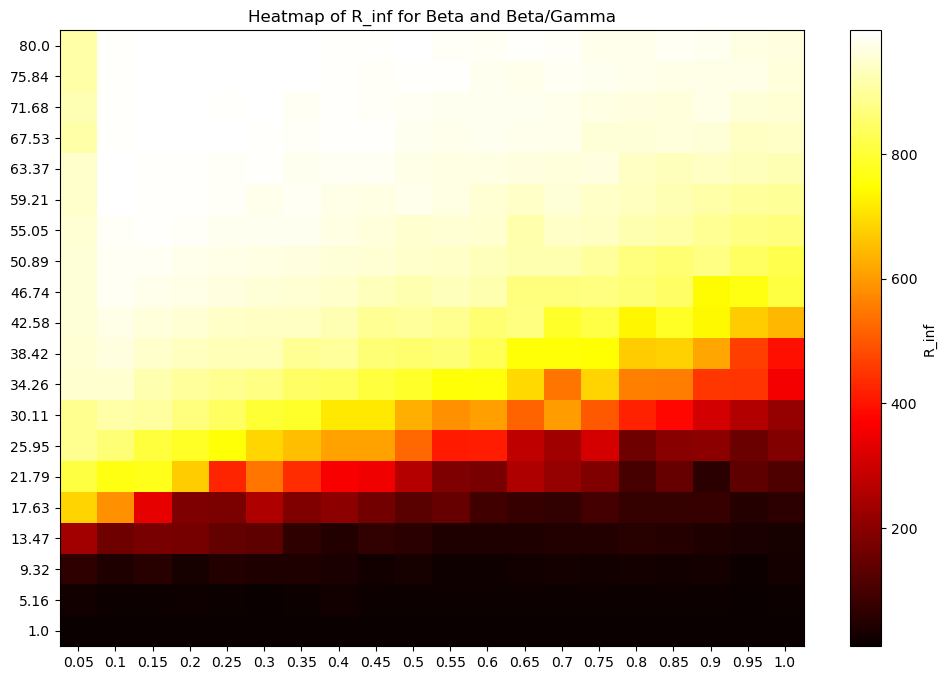

In [6]:
# beta and y ranges
beta_range = np.linspace(0.05, 1, 20)
y_range = np.linspace(1, 80, 20)[::-1]
num_sim = 3

R_inf_grid = np.zeros((len(beta_range), len(y_range)))

# Simulation for each combination of beta and y (correlates with gamma)
for i, beta in enumerate(beta_range):
    for j, y in enumerate(y_range):
        gamma = beta / y
        R_inf = 0
        for _ in range(num_sim):
            _, _, recovered = run_simulation(beta, gamma)
            R_inf += max(recovered)

        R_inf_grid[j, i] = R_inf/num_sim

plt.figure(figsize=(12, 8))
plt.imshow(R_inf_grid, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='R_inf')

plt.yticks(np.arange(len(beta_range)), np.round(y_range, 2))
plt.xticks(np.arange(len(y_range)), np.round(beta_range, 2))

plt.title('Heatmap of R_inf for Beta and Beta/Gamma')
plt.show()